In [331]:
import tensorflow as tf
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns
import sklearn.metrics as sk_metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
import tempfile
import statsmodels.api as sm
import os
from tensorflow import keras
import statsmodels.formula.api as smf

from tensorflow.keras import layers
from sklearn.feature_selection import SelectKBest
from sklearn import metrics
import pymssql
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import RFE
from tqdm import tqdm
import numpy as np
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()
import math
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDRegressor
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.metrics import accuracy_score
from xgboost import plot_importance
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier, NeighborhoodComponentsAnalysis
from sklearn.pipeline import make_pipeline
from mpl_toolkits import mplot3d
import yaml
from scipy.stats import pearsonr
import decimal

random_state = 2023

# Preset matplotlib figure sizes.
matplotlib.rcParams['figure.figsize'] = [9, 6]

print(tf.__version__)
# To make the results reproducible, set the random seed value.
tf.random.set_seed(22)

with open("config.yaml") as f:
    config = yaml.load(f, Loader=yaml.FullLoader)

server_info = config["server"]

print(config)

2.9.0
{'server': {'name': 'localhost', 'user': 'sa', 'password': 'Passw0rd!', 'database': 'Loans_2023_01_27'}, 'tables': [{'name': 'dbo.UnderwritingData', 'primary': 'VIN', 'secondary': 'CreaditScore', 'null_secondary': 0}, {'name': 'dbo.RawAlgorithmData', 'primary': 'Vin6', 'secondary': 'Score', 'null_secondary': 0}], 'predictions': {'target': 'ProcStatsCd', 'replace': {'CL': 1, 'CO': 0}, 'doSpecial': True, 'special': 'DelqPct'}, 'ignore': ['Class_', 'AccountShort', 'CustomerNumber', 'CurBalAmt', 'Customer', 'AdminStatus', 'NumberPmnt', 'NumberPmnt', 'ResultCD', 'ChargeOffDt', 'PercentageOfPaymentsMade', 'DelqCalcAlert', 'RecyCalcAlert', 'ApplicationNumber', 'CurrentPaymentsMade', 'Name'], 'outliers': {'ignore': ['Status', 'DelqPct', 'CreaditScore', 'HomeOwner', 'Reposessions', 'Chageoff', 'APR']}}


In [333]:
class DatabaseLoader:
    def __init__(self, _server_info):
        _conn = pymssql.connect(server=server_info['name'], user=server_info['user'], password=server_info['password'], database=server_info['database'])

        self._cursor = _conn.cursor()
        self._empty = True
        self.df = None
        self._global_primary = None
        self._global_secondary = None
        self._global_primary_type = None
        self._global_secondary_type = None
        self._target = None
        self._special_target = None

    def get_column_index(self, _column_name):
        for index, col in enumerate(self._cursor.description):
            if col[0] == _column_name:
                return index

    def replace_col_name(self, _cur_headers, _old, _new):
        for idx, header in enumerate(_cur_headers):
            if header==_old:
                _cur_headers[idx] = _new

    def load_table(self, _table_info, ignore=None):
        if ignore is None:
            ignore = []
        self._cursor.execute("SELECT * FROM {table}".format(table=_table_info['name']))

        _headers = []
        _rows = []

        for entity in self._cursor.description:
            _headers.append(entity[0])

        _primary_index = self.get_column_index(_table_info['primary'])
        _secondary_index = self.get_column_index(_table_info['secondary'])

        _res = self._cursor.fetchone()
        while _res:
            _row = [element for element in _res]
            if _row[_primary_index] is not None and _row[_primary_index].strip() != "n/a" and _row[_secondary_index] != _table_info['null_secondary']:
                # Strips trailing whitespace from strings
                for idx, item in enumerate(_row):
                    if isinstance(item, str):
                        _row[idx] = item.strip()

                    if isinstance(item, decimal.Decimal):
                        _row[idx] = float(item)

                _rows.append(_row)
            _res = self._cursor.fetchone()

        if self._empty:
            self._empty = False
            self.df = pd.DataFrame(_rows, columns=_headers)
            self._global_primary = _table_info['primary']
            self._global_secondary = _table_info['secondary']
            self._global_primary_type = type(self.df[self._global_primary].iloc[0])
            self._global_secondary_type = type(self.df[self._global_secondary].iloc[0])
        else:
            # Replace the primary and secondary key column names with the global primary and secondary key names
            self.replace_col_name(_headers, _table_info['primary'], self._global_primary)
            self.replace_col_name(_headers, _table_info['secondary'], self._global_secondary)

            temp_df = pd.DataFrame(_rows, columns = _headers)
            # Cast the primary and secondary keys to global type
            temp_df[self._global_primary] = temp_df[self._global_primary].astype(self._global_primary_type)
            temp_df[self._global_secondary] = temp_df[self._global_secondary].astype(self._global_secondary_type)

            self.df = pd.merge(temp_df, self.df, how = 'inner', on=['VIN', 'CreaditScore'])

        # Remove any columns to ignore
        self.df = self.df.drop(labels = ignore, axis=1, errors='ignore')

    def prune_for_target(self, _prediction_info):
        self._target = _prediction_info['target']
        _replace_guide = _prediction_info['replace']

        self.df = self.df[self.df[self._target].isin(list(_replace_guide.keys()))]
        for key, value in _replace_guide.items():
            self.df[self._target].replace(to_replace=key, value=value, inplace=True)

        # Move the target to the end of the dataframe
        cols = list(self.df.columns)
        cols.remove(self._target)
        cols.append(self._target)
        self.df = self.df[cols]

        if _prediction_info['doSpecial']:
            if _prediction_info['special'] == 'DelqPct':
                self.df = self.df[self.df['OpeningBalance']!=0]
                self.df['DelqPct'] = self.df.apply(lambda row : (100*row['Delq'])/row['OpeningBalance'],axis=1)

                # Remove the old target and Delq from the dataframe
                cols = list(self.df.columns)
                cols.remove(self._target)
                cols.remove("Delq")
                self.df = self.df[cols]
                self._target = "DelqPct"


    def remove_majority_null(self, threshold = .7):
        total = len(self.df)
        cols_to_drop = []
        percents = []
        for column in self.df.columns:
            non_null_count = 0
            for idx, item in self.df[column].items():
                if item is not None:
                    non_null_count +=1
            percent = float(non_null_count)/float(total)
            if percent < threshold:
                cols_to_drop.append(column)
                percents.append((1-percent)*100)

        self.df = self.df.drop(cols_to_drop, axis = 1)
        for idx, column in enumerate(cols_to_drop):
            print("Dropping {column} since {percent}% of entires were Null".format(column=column, percent = percents[idx]))

    def contains_null_or_is_categorical(self, series):
        if self.is_categorical(series):
            return True

        for idx, item in series.items():
            if item is None:
                return True

        return False

    def get_type_series(self, series):
        for idx, item in series.items():
            if item is not None:
                return type(item)
        return None

    def is_categorical(self, series):
        return self.get_type_series(series) == str

    def get_correlated_entities(self, threshold = 0.1):
        corrs = dict()
        for col in self.df.columns:
            if col == self._target or self.contains_null_or_is_categorical(self.df[col]):
                continue
            corr, _ = pearsonr(self.df[col], self.df[self._target])
            corrs[col] = abs(corr)

        corrs = {k: v for k, v in sorted(corrs.items(), key=lambda item: item[1])}

        goodCols = []

        for col, score in corrs.items():
            if score>=threshold:
                goodCols.append(col)

        return df[goodCols]

    def remove_outliers(self, lower_thresh = 0.00, upper_thresh = 0.999, ignore=None):
        if ignore is None:
            ignore = []
        for col in self.df.columns:
            if col in ignore or col==self._target or self.is_categorical(self.df[col]):
                continue
            percentiles = self.df[col].quantile([lower_thresh, upper_thresh]).values
            self.df.loc[self.df[col]<=percentiles[0], col] = percentiles[0]
            self.df.loc[self.df[col]>=percentiles[1], col] = percentiles[1]

    def get_target_col(self):
        return self.df[self._target]

In [339]:
dbl = DatabaseLoader(server_info)

dbl.load_table(config['tables'][0], ignore=config['ignore'])
dbl.load_table(config['tables'][1], ignore=config['ignore'])
dbl.prune_for_target(config['predictions'])
dbl.remove_majority_null()

corents = dbl.get_correlated_entities()
print("Most Correlated Columns")
print(corents.columns)

dbl.remove_outliers(ignore = config['outliers']['ignore'])



# plt.scatter(df["CurrentPaymentsMade"], df["DelqPct"])
# plt.show()


# print(df)


Dropping Discount since 100.0% of entires were Null
Dropping CustomScore since 44.52901998097051% of entires were Null
Most Correlated Columns
Index(['Salary_y', 'NinetyDaysDelinquent', 'OpenTotalInBadStatus',
       'CreaditScore', 'CashDown', 'Term', 'OrigTerm', 'Apr', 'OpeningBalance',
       'Recy'],
      dtype='object')


/Users/nikhil/Documents/401/CODE/Scorelate/venv/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


In [193]:
def get_column_index(cursor, column_name):
    for index, col in enumerate(cursor.description):
        if col[0] == column_name:
            return index
additional_data_headers = ["RentMortgagePayment" ,"TotalIncome" ,"RentMortgage" ,"CarPayment" ,"Expenses" ,"AvailableIncome" ,"Miles"]
additional_data_sql = "VIN,"
for i, header in enumerate(additional_data_headers):
    additional_data_sql += header
    if i!=len(additional_data_headers)-1:
        additional_data_sql+=','

In [ ]:
conn = pymssql.connect(server='localhost', user='sa', password='Passw0rd!', database='Loans_2023_01_27')
cursor = conn.cursor()

headers = []
rows = []

# Underwriting Data
cursor.execute("SELECT * FROM dbo.UnderwritingData")

for entity in cursor.description:
    headers.append(entity[0])

vin_index = get_column_index(cursor, "VIN")

res = cursor.fetchone()
while res:
    row = [element for element in res]
    if row[vin_index] is not None:
        rows.append(row)
    res = cursor.fetchone()

df = pd.DataFrame(rows, columns=headers)
ids = [i for i in range(0, len(df))]
default_status = ["NA" for _ in range(len(df))]
default_delq = ["NA" for i in range(len(df))]
default_apr = ["NA" for _ in range(len(df))]
df["ID"] = ids
df["APR"] = default_apr
df["Status"] = default_status
df["Delq"] = default_delq
df = df[df['OpeningBalance']!=0]


#Raw algorithm data
headers = []
rawAlgRows =[]
cursor.execute("Select * FROM dbo.RawAlgorithmData")

for entity in cursor.description:
    headers.append(entity[0])

vin_index = get_column_index(cursor, "Vin6")

res = cursor.fetchone()
while res:
    row = [element for element in res]
    if row[vin_index] is not None:
        rawAlgRows.append(row)
    res = cursor.fetchone()

rawAlgDf = pd.DataFrame(rawAlgRows, columns=headers)
#prune extra space from end of vins
rawAlgDf['Vin6'] = rawAlgDf['Vin6'].apply(lambda x: x.strip())
df['VIN'] = df['VIN'].apply(lambda x: x.strip())


#matching by credit score
for idx, row in tqdm(rawAlgDf.iterrows()):
    vin = row["Vin6"]
    vinsFromUnder = df[df["VIN"]==vin]


    for index, match in vinsFromUnder.iterrows():
        matchID = match["ID"]
        underwritingCreditScore = (int)(match["CreaditScore"])
        rawCreditScore = (int)(row["Score"])

        #we don't want to match if the scores are zero, since that means they are missing
        if rawCreditScore==0:
            continue

        if underwritingCreditScore==rawCreditScore:
            df.loc[df["ID"]==matchID,"Status"]=row["ProcStatsCd"]
            df.loc[df["ID"]==matchID,"Delq"]=row["Delq"]
            df.loc[df["ID"]==matchID, "APR"] = int(row["Apr"] * 100) if row["Apr"] is not None else None #convert apr to an int

df = df[(df['Status']=='CO') | (df['Status']=='CL')]
df['Status'].replace(to_replace=['CO', 'CL'], value=[0,1], inplace=True)
df['HomeOwner'].replace(to_replace=['N', 'Y'], value=[0,1], inplace=True)
df['DelqPct'] = df.apply(lambda row : (100*row['Delq'])/row['OpeningBalance'],axis=1)
df.fillna(df.mean(), inplace=True)

#TODO maybe put back: CreaditScore, CurrentPaymentsMade, DelqPct
df = df[["OpeningBalance","Salary","Term","VehicleYear","LTV","DTI","TradelinesTotal","TradelinesBalance","Reposessions","Bankrupcies","Chageoff","Mortgage","NinetyDaysDelinquent","InquiresTotal","OpenTotal","ClosedTotalTermsNotPaid","LatePaymentHistory001230","LatePaymentHistory001260","LatePaymentHistory001290Plus","PaidAccounts","InquiriesLast6Months","OpenTotalInBadStatus","RentMortgage","CashDown","HomeOwner", "APR", "Status"]]

#outlier handling
for col in df.columns:
    if(col in ["Status", "DelqPct", "CreaditScore", "HomeOwner", "Reposessions", "Chageoff", "APR"]):
        continue
    percentiles = df[col].quantile([0.00, 0.999]).values
    df.loc[df[col]<=percentiles[0], col] = percentiles[0]
    df.loc[df[col]>=percentiles[1], col] = percentiles[1]

In [127]:
def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

In [128]:
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 28)               57        
 n)                                                              
                                                                 
 dense (Dense)               (None, 64)                1856      
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 6,138
Trainable params: 6,081
Non-trainable params: 57
_________________________________________________________________


In [129]:
%%time
history = dnn_model.fit(
    train_features,
    train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

2023-03-22 20:31:18.427626: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-03-22 20:31:20.659949: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


CPU times: user 58.4 s, sys: 26.1 s, total: 1min 24s
Wall time: 1min 17s


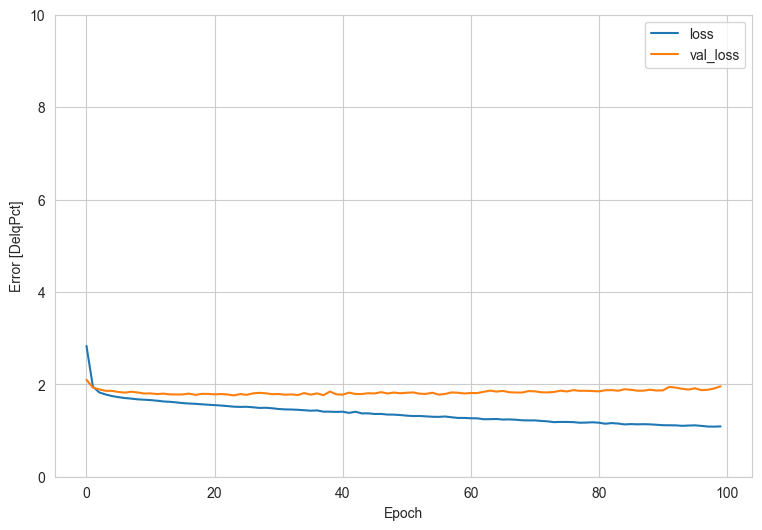

In [130]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error [DelqPct]')
  plt.legend()
  plt.grid(True)

plot_loss(history)

#Overfitting is when the model fits the training data too closely, and the loss keeps decreasing while the val_loss is stale, or increases.
#which looks to be exactly what is happening here

In [131]:
test_results = dict()
test_results['dnn_model'] = dnn_model.evaluate(test_features, test_labels, verbose=0)
pd.DataFrame(test_results, index=['Mean absolute error [DelqPCT]']).T

,Mean absolute error [DelqPCT]
dnn_model,1.854188


53/53 [==============================] - 0s 2ms/step


2023-03-22 20:32:36.499690: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[ 2.495012   2.9536889  1.1269145 10.562564   4.541607 ]
         DelqPct
758    10.307537
10236   2.090715
365    11.509895
8703    8.409959
13633   2.830383


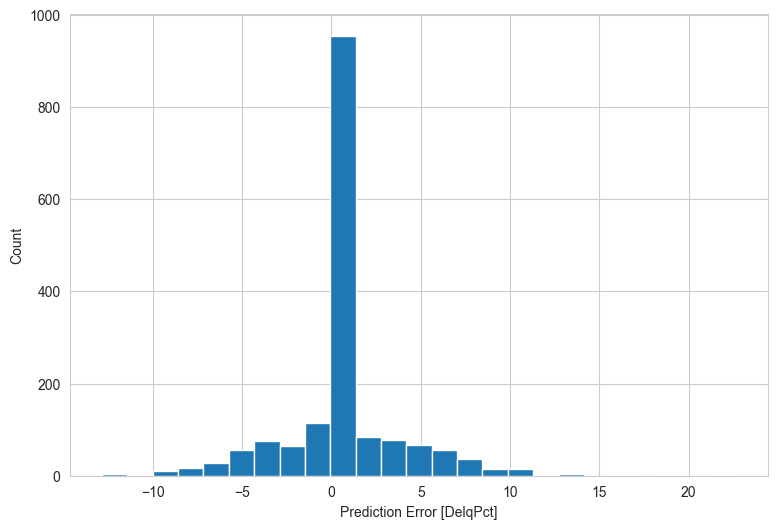

In [132]:
test_predictions = dnn_model.predict(test_features).flatten()

print(test_predictions[:5])
print(test_labels[:5])

error = test_predictions.reshape(test_predictions.shape[0],1) - test_labels
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [DelqPct]')
_ = plt.ylabel('Count')

## KNN

In [236]:
knn = KNeighborsClassifier(n_neighbors=10, weights='uniform')
knndata = df.copy(deep=True)


x_train, x_test, y_train, y_test = train_test_split(knndata.iloc[:,:-1], knndata.iloc[:,-1:], test_size=0.2)
knn.fit(x_train, y_train)

res = knn.predict(x_test)
preds = []
actual = []
for pred in res:
    if(pred==1):
        preds.append("Paid")
    else:
        preds.append("CO")

for result in y_test["Status"]:
    if result == 0:
        actual.append("Paid")
    else:
        actual.append("CO")

paidandpredpaid = 0
paidandpredco = 0
coandpredpaid = 0
coandpredco = 0

avgPaid = []
avgCO = []

for i in range(len(preds)):
    if preds[i]=="Paid" and actual[i]=="Paid":
        paidandpredpaid+=1
    elif preds[i]=="CO" and actual[i]=="Paid":
        paidandpredco+=1
    elif preds[i]=="Paid" and actual[i]=="CO":
        coandpredpaid+=1
    elif preds[i]=="CO" and actual[i]=="CO":
        coandpredco+=1
    if(actual[i]=="Paid"):
        avgPaid.append(res[i])
    else:
        avgCO.append(res[i])

print("Paid and Pred Paid: ", paidandpredpaid)
print("Paid and Pred CO: ", paidandpredco)
print("CO and Pred Paid: ", coandpredpaid)
print("CO and Pred CO: ", coandpredco)

print("Avg Paid: ", sum(avgPaid)/len(avgPaid))
print("Avg CO: ", sum(avgCO)/len(avgCO))

train_confusion = metrics.confusion_matrix(y_train, knn.predict(x_train))
test_confusion = metrics.confusion_matrix(y_test, res)
print("Training Confusion Matrix: ")
print(train_confusion)
print("Test Confusion Matrix: ")
print(test_confusion)

/Users/nikhil/Documents/401/CODE/Scorelate/venv/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


Paid and Pred Paid:  304
Paid and Pred CO:  536
CO and Pred Paid:  347
CO and Pred CO:  494
Avg Paid:  0.3619047619047619
Avg CO:  0.4126040428061831
Training Confusion Matrix: 
[[2483  782]
 [1588 1868]]
Test Confusion Matrix: 
[[536 304]
 [494 347]]
Test Data ROC and AUC
5751     0
5920     0
13995    1
4548     0
3871     0
        ..
1669     1
3500     1
9319     0
6916     0
8031     1
Name: Status, Length: 1681, dtype: int64


/Users/nikhil/Documents/401/CODE/Scorelate/venv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:769: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  y_true = y_true == pos_label


TypeError: 'bool' object is not subscriptable

/Users/nikhil/Documents/401/CODE/Scorelate/venv/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/var/folders/kh/np0tdw052gg77h97rt6rm3l80000gn/T/ipykernel_49003/1420977699.py:57: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  sctt = ax.scatter3D(X_embedded[:, 0], X_embedded[:, 1], X_embedded[:, 2], c=col, s=30, cmap="Set1")


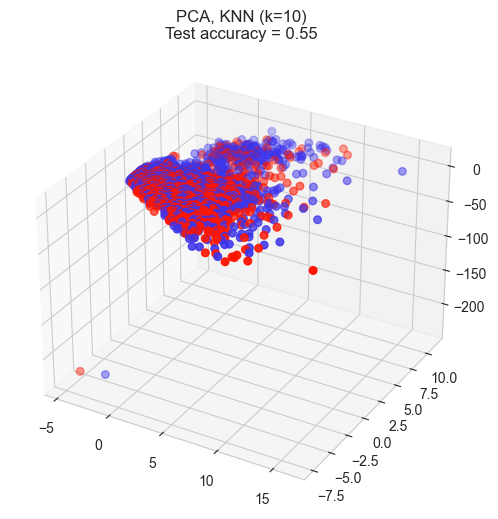

In [283]:
#PCA

X = knndata.iloc[:,:-1]
Y = knndata.iloc[:,-1:]

# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.5, random_state = random_state
)


n_neighbors = 10
# dim = len(X[0])
n_classes = len(np.unique(Y))

# Reduce dimension to 2 with PCA
pca = make_pipeline(StandardScaler(), PCA(n_components=3, random_state=random_state))

# Reduce dimension to 2 with LinearDiscriminantAnalysis
lda = make_pipeline(StandardScaler(), LinearDiscriminantAnalysis(n_components=2))

# Reduce dimension to 2 with NeighborhoodComponentAnalysis
nca = make_pipeline(
    StandardScaler(),
    NeighborhoodComponentsAnalysis(n_components=2, random_state=random_state),
)

# Use a nearest neighbor classifier to evaluate the methods
knn = KNeighborsClassifier(n_neighbors=n_neighbors)

# Make a list of the methods to be compared
dim_reduction_methods = [("PCA", pca)]#, ("LDA", lda), ("NCA", nca)]

# plt.figure()
for i, (name, model) in enumerate(dim_reduction_methods):
    plt.figure()
    # plt.subplot(1, 3, i + 1, aspect=1)

    # Fit the method's model
    model.fit(X_train, y_train)

    # Fit a nearest neighbor classifier on the embedded training set
    knn.fit(model.transform(X_train), y_train)

    # Compute the nearest neighbor accuracy on the embedded test set
    acc_knn = knn.score(model.transform(X_test), y_test)

    # Embed the data set in 2 dimensions using the fitted model
    X_embedded = model.transform(X)

    colors = np.array(["#ff1500", "#3d34eb"])

    col = [i[0] for i in colors[Y]]

    # Plot the projected points and show the evaluation score
    ax = plt.axes(projection='3d')
    sctt = ax.scatter3D(X_embedded[:, 0], X_embedded[:, 1], X_embedded[:, 2], c=col, s=30, cmap="Set1")
    plt.title(
        "{}, KNN (k={})\nTest accuracy = {:.2f}".format(name, n_neighbors, acc_knn)
    )

    # vis = PCA(scale=True, projection=3, classes=[0,1], colors=['red', 'blue'])
    # vis.fit_transform(X, Y)
    # vis.show(outpath="../plot.png")
plt.show()

## XGBoost

In [172]:
xgdata = df.copy(deep=True)
x_train, x_test, y_train, y_test = train_test_split(xgdata.iloc[:,:-1], xgdata.iloc[:,-1:], test_size=0.2)#TODO if more than one epoch move this back inside loop
for x in tqdm(range(1)):
    train = xgb.DMatrix(x_train, label=y_train, enable_categorical=True)
    test = xgb.DMatrix(x_test, label=y_test, enable_categorical=True)

    param = {
        'eta': 0.01,
        'objective': 'reg:squarederror',
    }
    epochs = 500

    model = xgb.train(param, train, epochs)

    predictions = model.predict(test)

    y = []

    for z in predictions:
        y.append(np.argmax(z))

    acc = round(metrics.mean_squared_error(y_test, y, squared=False), 3)
    model.save_model('Models/Delq/XGBoost_{}%_Scorelate.json'.format(acc))

100%|██████████| 1/1 [00:12<00:00, 12.09s/it]


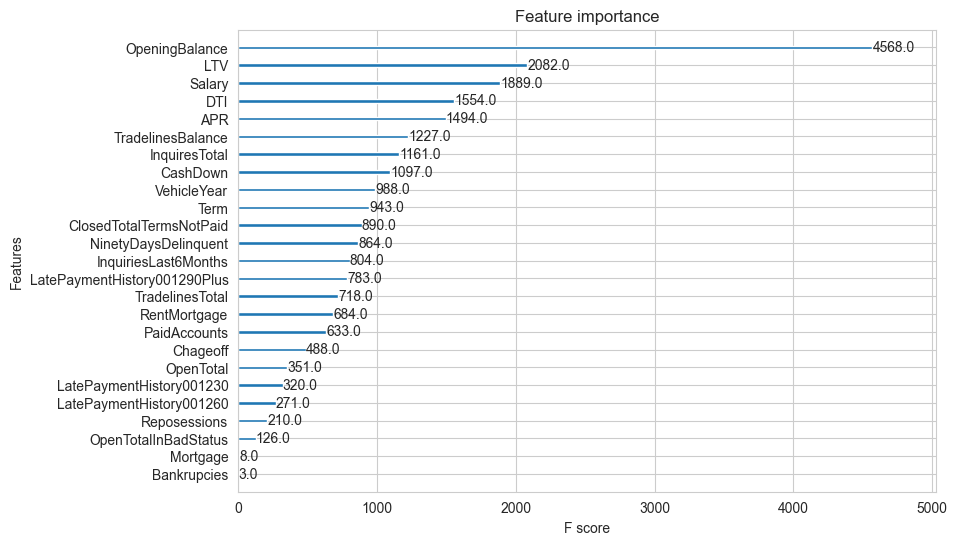

In [180]:
xgb_ml = xgb.Booster()

xgb_ml.load_model('Models/Delq/XGBoost_6.765%_Scorelate.json')
# x_train, x_test, y_train, y_test = train_test_split(df.iloc[:,:-1], df.iloc[:,-1:], test_size=0.2)
# print(xgb_ml.predict(xgb.DMatrix(x_test[:5])))
# print(y_test[:5])

# plot feature importance
plot_importance(xgb_ml)
plt.show()

In [179]:
res = xgb_ml.predict(xgb.DMatrix(x_test))
preds = []
actual = []
for pred in res:
    if(pred<3.5):
        preds.append("Paid")
    else:
        preds.append("CO")

for result in y_test["DelqPct"]:
    if result == 0.0:
        actual.append("Paid")
    else:
        actual.append("CO")

paidandpredpaid = 0
paidandpredco = 0
coandpredpaid = 0
coandpredco = 0

avgPaid = []
avgCO = []

for i in range(len(preds)):
    if preds[i]=="Paid" and actual[i]=="Paid":
        paidandpredpaid+=1
    elif preds[i]=="CO" and actual[i]=="Paid":
        paidandpredco+=1
    elif preds[i]=="Paid" and actual[i]=="CO":
        coandpredpaid+=1
    elif preds[i]=="CO" and actual[i]=="CO":
        coandpredco+=1
    if(actual[i]=="Paid"):
        avgPaid.append(res[i])
    else:
        avgCO.append(res[i])

print("Paid and Pred Paid: ", paidandpredpaid)
print("Paid and Pred CO: ", paidandpredco)
print("CO and Pred Paid: ", coandpredpaid)
print("CO and Pred CO: ", coandpredco)

print("Avg Paid: ", sum(avgPaid)/len(avgPaid))
print("Avg CO: ", sum(avgCO)/len(avgCO))

Paid and Pred Paid:  469
Paid and Pred CO:  439
CO and Pred Paid:  284
CO and Pred CO:  489
Avg Paid:  3.5644615028747912
Avg CO:  4.251317676643505
